<a href="https://colab.research.google.com/github/beyzoskaya/PyTorch_deepLearning/blob/main/extras/family_recognition_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

In [2]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
from google.colab import files
uploaded = files.upload()

Saving family recognition.zip to family recognition.zip


In [5]:
from google.colab.files import upload
import zipfile
import io

zipped_family_recognition = "family recognition.zip"
family_recognition_data_path = "extracted_data"

with zipfile.ZipFile(zipped_family_recognition, "r") as zip_ref:
    zip_ref.extractall(family_recognition_data_path)

In [6]:
general_dir = "family recognition"
binary_classification_subdir = "person or not"
binary_classification_recognition_subdir = "person or not recognition"

In [7]:
import os

train_dir_binary_classification = os.path.join(family_recognition_data_path, general_dir,binary_classification_subdir, binary_classification_recognition_subdir, "train")
test_dir_binary_classification = os.path.join(family_recognition_data_path, general_dir, binary_classification_subdir, binary_classification_recognition_subdir, "test")

In [8]:
train_dir_binary_classification, test_dir_binary_classification

('extracted_data/family recognition/person or not/person or not recognition/train',
 'extracted_data/family recognition/person or not/person or not recognition/test')

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from PIL import Image

person_train_dir = os.path.join(train_dir_binary_classification, "person")
not_person_train_dir = os.path.join(train_dir_binary_classification, "not person")
def display_random_images(image_dir,
                          classification_category,
                          num_images:int=3):

  image_file_names = os.listdir(image_dir)
  random.shuffle(image_file_names)

  plt.figure(figsize=(16,8))

  for i in range(num_images):
    image_name = image_file_names[i]
    image_path = os.path.join(image_dir, image_name)
    img = Image.open(image_path)
    width, height = img.size
    print(f"Image dimensions: {width} x {height}")
    plt.subplot(1, num_images, i+1)
    plt.imshow(img)
    plt.title(f"{classification_category.capitalize()} Image")
    plt.axis(False)

  plt.show()

Image dimensions: 225 x 225
Image dimensions: 1157 x 1620
Image dimensions: 1920 x 1080


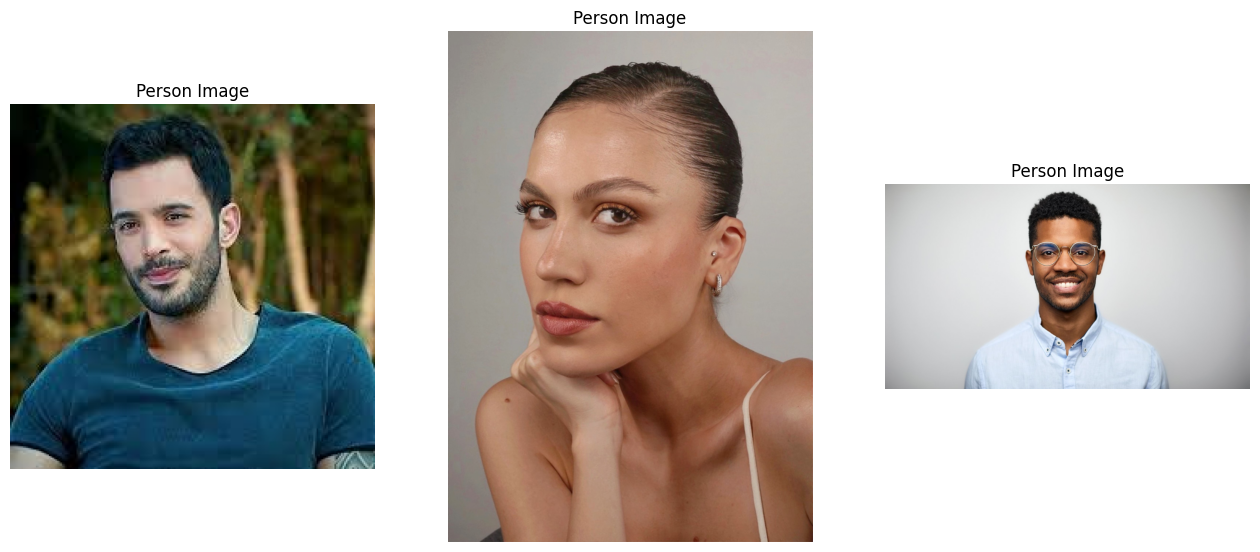

In [10]:
display_random_images(person_train_dir, "person")

Image dimensions: 1280 x 720
Image dimensions: 408 x 612
Image dimensions: 768 x 384


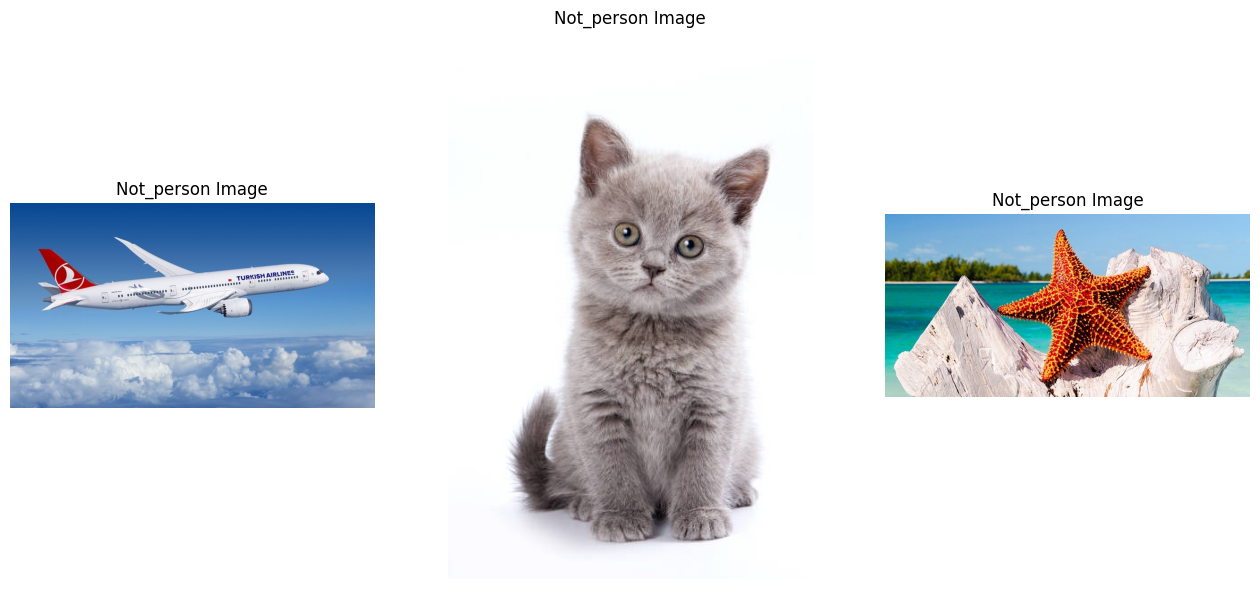

In [11]:
display_random_images(not_person_train_dir, "not_person")

In [12]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [13]:
import torchvision

def create_vit_model(num_classes:int=2,
                     seed:int=42):

  vit_b_16_weigths = torchvision.models.ViT_B_16_Weights.DEFAULT
  vit_b_16_transforms = vit_b_16_weigths.transforms()
  vit_b_16_model = torchvision.models.vit_b_16(weights=vit_b_16_weigths)

  for param in vit_b_16_model.parameters():
    param.requires_grad = False

  torch.manual_seed(42)
  vit_b_16_model.heads = nn.Sequential(
      nn.Linear(in_features=768,
                out_features=num_classes))

  return vit_b_16_model, vit_b_16_transforms


In [14]:
vit_model, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:18<00:00, 18.9MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [15]:
summary(vit_model,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 2]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [16]:
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

#class RandomGaussianNoise(object):
#  def __init__(self,
#               mean=0,
#               std=1):
#    self.mean = mean
#    self.std = std

#  def __call__(self,image):
#    image = np.array(image) # PIL image to NumPy array for math operations
#    noise = np.random.normal(self.mean, self.std, image.shape).astype(np.uint8) # Create noise for image then retyped for get the same shape (both noise and image)
#    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8) # Add noise to the image
#    return Image.fromarray(noisy_image)


In [17]:
import torchvision.transforms as transforms

vit_b_16_transforms = vit_transforms

additional_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),

])

combined_transform = transforms.Compose([
    vit_b_16_transforms,
    additional_augmentations,
])

In [18]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Create dataset objects for the train and test sets
train_dataset = ImageFolder(train_dir_binary_classification, transform=combined_transform)
test_dataset = ImageFolder(test_dir_binary_classification, transform=combined_transform)

# Create data loaders for the train and test sets
batch_size = 1  # Adjust as needed
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
len(train_dataloader), len(test_dataloader)

(38, 20)

In [20]:
class_names = train_dataset.classes

In [21]:
#from torchvision import datasets, transforms
#train_data = datasets.ImageFolder(train_dir_binary_classification, transform=vit_transform)

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit_model.parameters(),
                             lr=1e-3)

In [23]:
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device) -> Tuple[float, float]:

  model.train()
  train_loss, train_acc = 0,0

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss=loss_fn(y_pred, y)
    train_loss = train_loss + loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1), dim=1)
    train_acc = train_acc + (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test(model:torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        device: torch.device) -> Tuple[float, float]:
  model.eval()
  test_loss, test_acc = 0,0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logit = model(X)
      loss = loss_fn(test_pred_logit, y)
      test_loss = test_loss + loss.item()

      test_pred_labels = test_pred_logit.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

from numpy.random import test
def train_results(model: torch.nn.Module,
                  train_dataloader: torch.utils.data.DataLoader,
                  test_dataloader: torch.utils.data.DataLoader,
                  optimizer: torch.optim.Optimizer,
                  loss_fn: torch.nn.Module,
                  epochs:int,
                  device: torch.device) -> Dict[str, List]:

  results = {"train_loss": [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []
            }

  model.to(device)

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)
      test_loss, test_acc = test(model=model,
                                dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                device=device)

      # Print out what's happening
      print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [24]:
vit_b_16_results = train_results(vit_model,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=optimizer,
                                loss_fn = loss_fn,
                                epochs=5,
                                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TypeError: ignored

In [25]:
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3905, done.
remote: Counting objects: 100% (1096/1096), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 3905 (delta 986), reused 985 (delta 936), pack-reused 2809
Receiving objects: 100% (3905/3905), 649.58 MiB | 24.61 MiB/s, done.
Resolving deltas: 100% (2277/2277), done.
Updating files: 100% (248/248), done.


In [26]:
from going_modular.going_modular import engine
vit_b_16_results = engine.train (vit_model,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=optimizer,
                                loss_fn = loss_fn,
                                epochs=5,
                                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1 | train_loss: 0.2895 | train_acc: 0.9737 | test_loss: 0.2132 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.1352 | train_acc: 1.0000 | test_loss: 0.1536 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.1052 | train_acc: 1.0000 | test_loss: 0.1390 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.0801 | train_acc: 1.0000 | test_loss: 0.1239 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0507 | train_acc: 1.0000 | test_loss: 0.1021 | test_acc: 1.0000


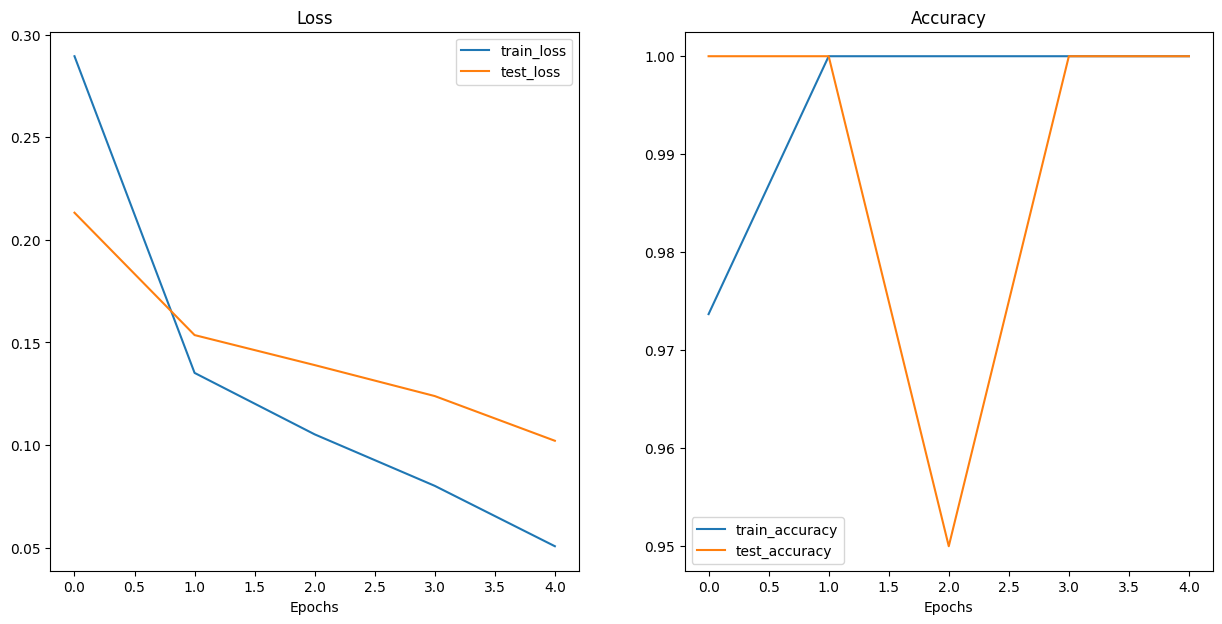

In [27]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_b_16_results)

In [28]:
from pathlib import Path

test_data_paths = list(Path(train_dir_binary_classification).glob("*/*jpeg"))
test_data_paths[:5]

[PosixPath('extracted_data/family recognition/person or not/person or not recognition/train/not person/not person-3.jpeg'),
 PosixPath('extracted_data/family recognition/person or not/person or not recognition/train/not person/not person-2.jpeg'),
 PosixPath('extracted_data/family recognition/person or not/person or not recognition/train/not person/not person-4.jpeg'),
 PosixPath('extracted_data/family recognition/person or not/person or not recognition/train/not person/not person-1.jpeg'),
 PosixPath('extracted_data/family recognition/person or not/person or not recognition/train/not person/not person-13.jpeg')]

In [29]:
class_names = train_dataset.classes
print(class_names)

['not person', 'person']


In [30]:
import pathlib
from tqdm.auto import tqdm
from timeit import default_timer as timer
from PIL import Image
from typing import Dict, List, Tuple

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform:torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu"
                   ) -> List[Dict]:
  pred_list = []

  for path in tqdm(paths):
    pred_dict = {}
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    #print(class_names)
    pred_dict["class_name"] = class_name

    start_time = timer()

    img = Image.open(path)

    transformed_image = transform(img).unsqueeze(0).to(device)

    model=model.to(device)

    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(),4)
      pred_dict["pred_class"] = pred_class

      end_time = timer()
      pred_dict["time_for_prediction"] = round(end_time-start_time,4)

    pred_dict["correct"] = class_name == pred_class
    pred_list.append(pred_dict)

  return pred_list


In [31]:
vit_b_16_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=vit_model,
                                          transform=combined_transform,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/38 [00:00<?, ?it/s]

In [32]:
vit_b_16_test_pred_dicts[:2]

[{'image_path': PosixPath('extracted_data/family recognition/person or not/person or not recognition/train/not person/not person-3.jpeg'),
  'class_name': 'not person',
  'pred_prob': 0.9195,
  'pred_class': 'not person',
  'time_for_prediction': 0.7839,
  'correct': True},
 {'image_path': PosixPath('extracted_data/family recognition/person or not/person or not recognition/train/not person/not person-2.jpeg'),
  'class_name': 'not person',
  'pred_prob': 0.9472,
  'pred_class': 'not person',
  'time_for_prediction': 0.7487,
  'correct': True}]

In [33]:
import pandas as pd
vit_b_16_test_pred_df = pd.DataFrame(vit_b_16_test_pred_dicts)
vit_b_16_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_prediction,correct
0,extracted_data/family recognition/person or no...,not person,0.9195,not person,0.7839,True
1,extracted_data/family recognition/person or no...,not person,0.9472,not person,0.7487,True
2,extracted_data/family recognition/person or no...,not person,0.9369,not person,0.7438,True
3,extracted_data/family recognition/person or no...,not person,0.9783,not person,0.7764,True
4,extracted_data/family recognition/person or no...,not person,0.9454,not person,1.0725,True


In [34]:
vit_b_16_test_pred_df.correct.value_counts()

True    38
Name: correct, dtype: int64

In [35]:
vit_average_time_per_pred = round(vit_b_16_test_pred_df.time_for_prediction.mean(),4)
vit_average_time_per_pred

0.856

In [36]:
vgg_weights = torchvision.models.VGG16_Weights.DEFAULT
vgg_transforms = vgg_weights.transforms()
vgg_model = torchvision.models.vgg16(weights=vgg_weights)

vgg_model.classifier

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 232MB/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [37]:
from torch import nn

def create_vgg_model(num_classes: int=2,
                     device=device):

  vgg_weights = torchvision.models.VGG16_Weights.DEFAULT
  vgg_transforms = vgg_weights.transforms()
  vgg_model = torchvision.models.vgg16(weights=vgg_weights)

  for param in vgg_model.parameters():
    param.requires_grad = False

  vgg_model.classifier = nn.Sequential(
      nn.Linear(in_features=25088, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=4096, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=4096, out_features=2, bias=True)
  )

  return vgg_transforms, vgg_model


In [38]:
vgg_transforms, vgg_model = create_vgg_model()
vgg_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [39]:
summary(vgg_model,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [1, 3, 224, 224]     [1, 2]               --                   Partial
├─Sequential (features)                  [1, 3, 224, 224]     [1, 512, 7, 7]       --                   False
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 64, 224, 224]    (1,792)              False
│    └─ReLU (1)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─Conv2d (2)                        [1, 64, 224, 224]    [1, 64, 224, 224]    (36,928)             False
│    └─ReLU (3)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─MaxPool2d (4)                     [1, 64, 224, 224]    [1, 64, 112, 112]    --                   --
│    └─Conv2d (5)                        [1, 64, 112, 112]    [1, 128, 112, 112]   (73,856)             False
│    └─ReLU (

In [40]:
import torchvision.transforms as transforms

additional_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),

])

combined_transform_vgg = transforms.Compose([
    vgg_transforms,
    additional_augmentations,
])

In [41]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Create dataset objects for the train and test sets
train_dataset = ImageFolder(train_dir_binary_classification, transform=combined_transform_vgg)
test_dataset = ImageFolder(test_dir_binary_classification, transform=combined_transform_vgg)

# Create data loaders for the train and test sets
batch_size = 1  # Adjust as needed
train_dataloader_vgg = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader_vgg = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [42]:
vgg_results = engine.train (vgg_model,
                                train_dataloader=train_dataloader_vgg,
                                test_dataloader=test_dataloader_vgg,
                                optimizer=optimizer,
                                loss_fn = loss_fn,
                                epochs=5,
                                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1 | train_loss: 0.7071 | train_acc: 0.3684 | test_loss: 0.6786 | test_acc: 0.6500
Epoch: 2 | train_loss: 0.6910 | train_acc: 0.5000 | test_loss: 0.6951 | test_acc: 0.5000
Epoch: 3 | train_loss: 0.6940 | train_acc: 0.5263 | test_loss: 0.6967 | test_acc: 0.5000
Epoch: 4 | train_loss: 0.7074 | train_acc: 0.3684 | test_loss: 0.7025 | test_acc: 0.5000
Epoch: 5 | train_loss: 0.7034 | train_acc: 0.3947 | test_loss: 0.6977 | test_acc: 0.5000


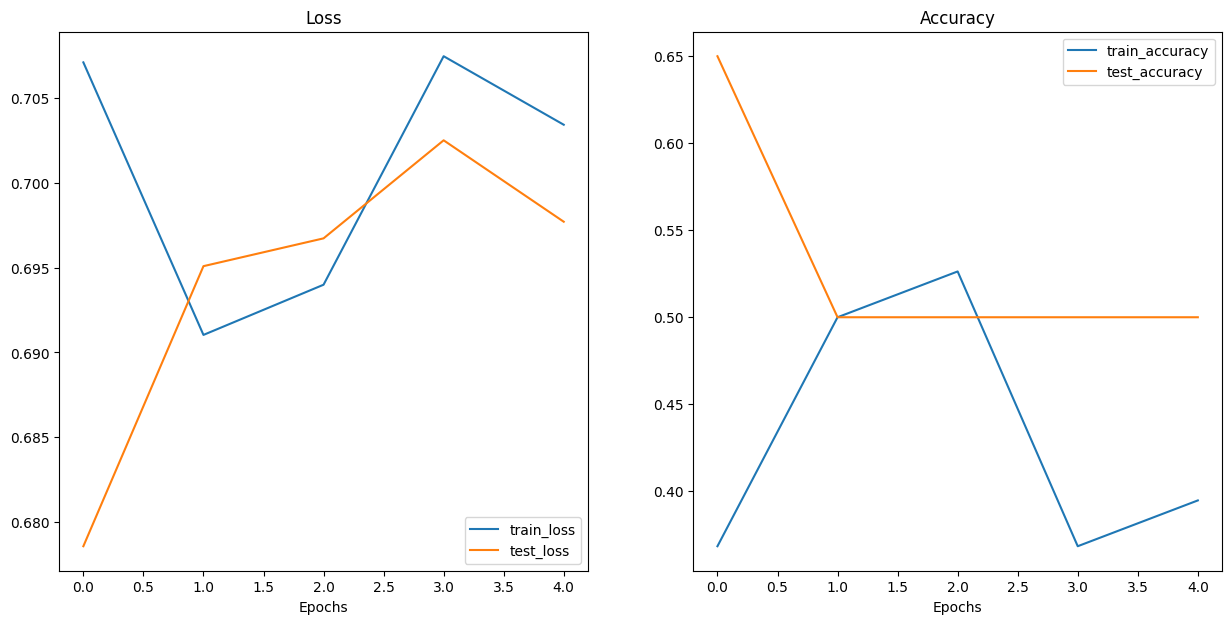

In [43]:
from helper_functions import plot_loss_curves

plot_loss_curves(vgg_results)

In [44]:
vgg_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=vgg_model,
                                          transform=combined_transform_vgg,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/38 [00:00<?, ?it/s]

In [45]:
vgg_test_pred_dicts[:5]

[{'image_path': PosixPath('extracted_data/family recognition/person or not/person or not recognition/train/not person/not person-3.jpeg'),
  'class_name': 'not person',
  'pred_prob': 0.5013,
  'pred_class': 'person',
  'time_for_prediction': 0.5981,
  'correct': False},
 {'image_path': PosixPath('extracted_data/family recognition/person or not/person or not recognition/train/not person/not person-2.jpeg'),
  'class_name': 'not person',
  'pred_prob': 0.5143,
  'pred_class': 'not person',
  'time_for_prediction': 0.559,
  'correct': True},
 {'image_path': PosixPath('extracted_data/family recognition/person or not/person or not recognition/train/not person/not person-4.jpeg'),
  'class_name': 'not person',
  'pred_prob': 0.502,
  'pred_class': 'person',
  'time_for_prediction': 0.5679,
  'correct': False},
 {'image_path': PosixPath('extracted_data/family recognition/person or not/person or not recognition/train/not person/not person-1.jpeg'),
  'class_name': 'not person',
  'pred_prob':

In [46]:
import pandas as pd
df_vgg = pd.DataFrame(vgg_test_pred_dicts)
df_vgg.head()

,image_path,class_name,pred_prob,pred_class,time_for_prediction,correct
0,extracted_data/family recognition/person or no...,not person,0.5013,person,0.5981,False
1,extracted_data/family recognition/person or no...,not person,0.5143,not person,0.5590,True
2,extracted_data/family recognition/person or no...,not person,0.5020,person,0.5679,False
3,extracted_data/family recognition/person or no...,not person,0.5032,person,0.5867,False
4,extracted_data/family recognition/person or no...,not person,0.5045,person,0.5658,False


In [47]:

import os

general_dir = "family recognition"


train_dir_family_recognition = os.path.join(family_recognition_data_path, general_dir, "train")
test_dir_family_recognition = os.path.join(family_recognition_data_path, general_dir, "test")

In [48]:
train_dir_family_recognition, test_dir_family_recognition

('extracted_data/family recognition/train',
 'extracted_data/family recognition/test')

In [53]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def display_random_images_from_directory(image_dir, num_images=3):
    # List all subdirectories (family member classes) in the dataset directory
    family_members = os.listdir(image_dir)

    # Choose a random family member to display images from
    random_family_member = random.choice(family_members)

    # Get the path to the selected family member's directory
    family_member_dir = os.path.join(image_dir, random_family_member)

    # List all image files in the selected family member's directory
    image_files = [f for f in os.listdir(family_member_dir) if f.endswith('.jpg')]

    # Choose random images from the family member's directory
    random_images = random.sample(image_files, num_images)

    # Display the randomly selected images
    plt.figure(figsize=(16, 8))

    for i, image_name in enumerate(random_images):
        image_path = os.path.join(family_member_dir, image_name)
        img = Image.open(image_path)
        width, height = img.size
        print(f"Image dimensions: {width} x {height}")
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{random_family_member.capitalize()} Image")
        plt.axis(False)

    plt.show()

Image dimensions: 461 x 1202
Image dimensions: 371 x 900
Image dimensions: 506 x 1600


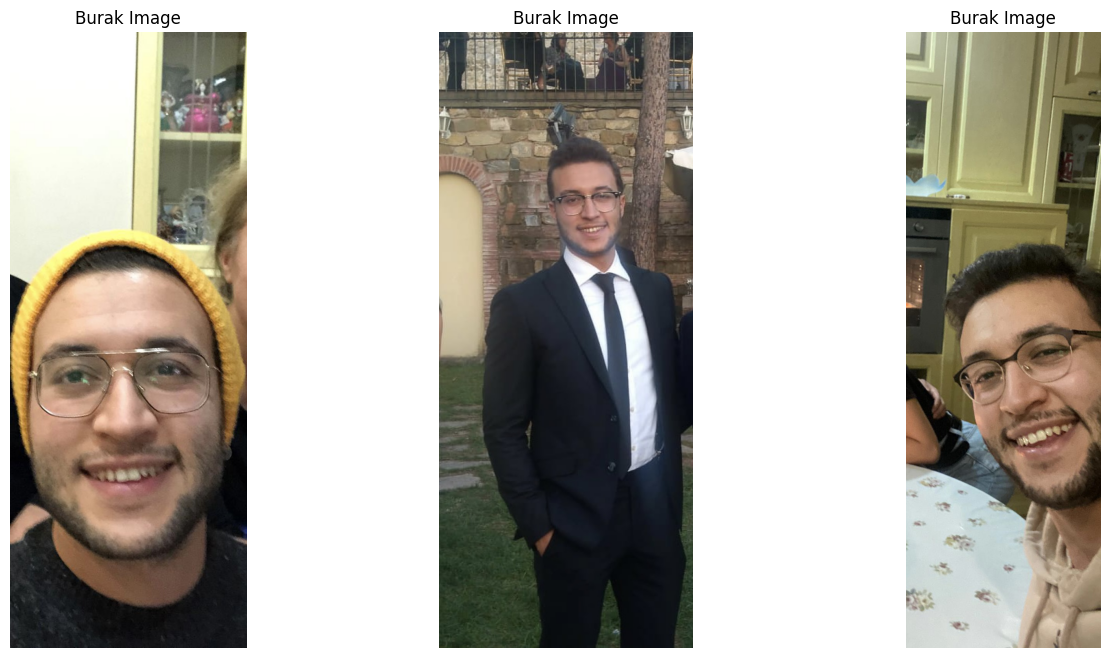

In [54]:
display_random_images_from_directory(train_dir_family_recognition, num_images=3)

Image dimensions: 461 x 1202
Image dimensions: 266 x 966


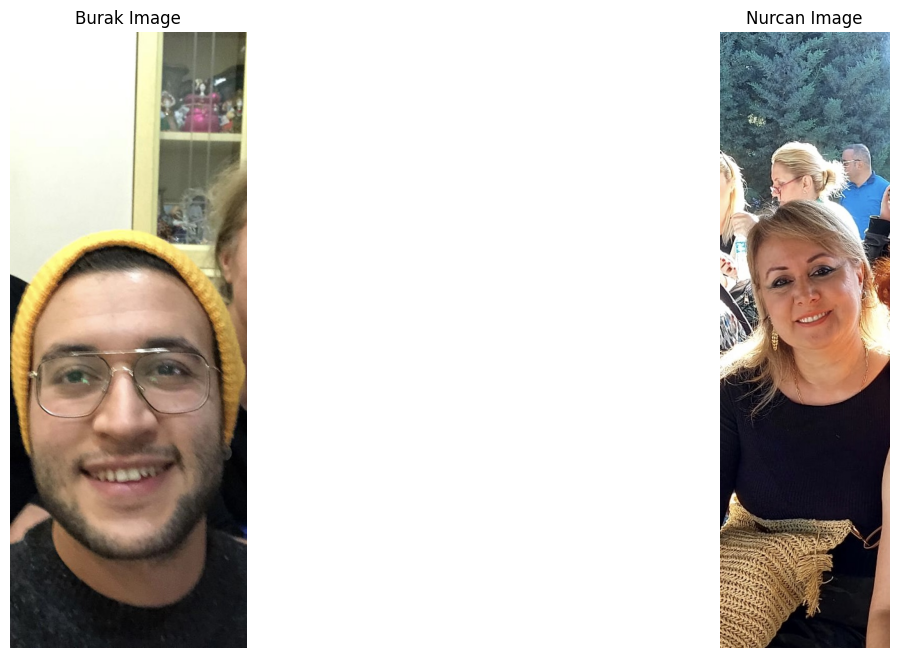

In [61]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def display_random_images(image_dir, num_images=3):

    family_members = os.listdir(image_dir)


    random_family_member1 = random.choice(family_members)
    random_family_member2 = random.choice([fm for fm in family_members if fm != random_family_member1])


    family_member_dir1 = os.path.join(image_dir, random_family_member1)
    family_member_dir2 = os.path.join(image_dir, random_family_member2)


    image_files1 = [f for f in os.listdir(family_member_dir1) if f.endswith('.jpg')]
    image_files2 = [f for f in os.listdir(family_member_dir2) if f.endswith('.jpg')]


    random_image1 = random.choice(image_files1)
    random_image2 = random.choice(image_files2)


    plt.figure(figsize=(16, 8))

    for i, image_path in enumerate([random_image1, random_image2]):
        img = Image.open(os.path.join(family_member_dir1 if i == 0 else family_member_dir2, image_path))
        width, height = img.size
        print(f"Image dimensions: {width} x {height}")
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{random_family_member1.capitalize() if i == 0 else random_family_member2.capitalize()} Image")
        plt.axis(False)

    plt.show()

# Call the function to display random images
display_random_images(train_dir_family_recognition, num_images=2)


In [57]:
vit_l_16_weights = torchvision.models.ViT_L_16_Weights.DEFAULT
vit_l_16_transforms = vit_l_16_weights.transforms()
vit_l_16_model = torchvision.models.vit_l_16(weights=vit_l_16_weights)

vit_l_16_model.heads

Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth
100%|██████████| 1.13G/1.13G [01:03<00:00, 19.3MB/s]


Sequential(
  (head): Linear(in_features=1024, out_features=1000, bias=True)
)

In [58]:
import torchvision

def create_vit_l_16_model(num_classes:int=5,
                          seed:int=42):
  vit_l_16_weights = torchvision.models.ViT_L_16_Weights.DEFAULT
  vit_l_16_transforms = vit_l_16_weights.transforms()
  vit_l_16_model = torchvision.models.vit_l_16(weights=vit_l_16_weights)

  for param in vit_l_16_model.parameters():
    param.requires_grad = False

  vit_l_16_model.heads = nn.Sequential(
      nn.Linear(in_features=1024,
                out_features=num_classes)
  )

  return vit_l_16_transforms, vit_l_16_model

In [62]:
vit_16_transform, vit_16_model = create_vit_l_16_model()
vit_16_transform

ImageClassification(
    crop_size=[224]
    resize_size=[242]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [73]:
import torch
import numpy as np

class RandomGaussianNoise:
    def __init__(self, mean=0, std=1):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        # Convert the image to a NumPy array
        img = np.array(img, dtype=np.float32)
        print(f"Data type for image: {img.dtype}")

        # Generate random Gaussian noise with the same shape as the image
        noise = np.random.normal(loc=self.mean, scale=self.std, size=img.shape)
        print(f"Data type for noise: {noise.dtype}")

        # Add the noise to the image
        noisy_img = img + noise
        print(f"Data type for added version: {noisy_img.dtype}")

        # Clip pixel values to ensure they are within the valid range (0-255 for 8-bit images)
        noisy_img = np.clip(noisy_img, 0, 255)
        print(f" Data type for noise: {noisy_img.dtype}")

        # Convert the noisy image back to the original data type
        noisy_img = noisy_img.astype(img.dtype)

        return noisy_img


In [74]:
import numpy as np

image_shape = (224, 224, 3)
dummy_image = np.zeros(image_shape, dtype=np.uint8)


noise_transform = RandomGaussianNoise(mean=0, std=1)


noisy_image = noise_transform(dummy_image)


Data type for image: float32
Data type for noise: float64
Data type for added version: float64
 Data type for noise: float64


In [88]:
def is_valid_file(file_name):
    return not file_name.startswith('.ipynb_checkpoints')

In [109]:
import torchvision.transforms as transforms
from PIL import Image

# Define a list of augmentations to apply randomly during training
vit_16_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop and resize
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust color
    transforms.RandomRotation(degrees=15),  # Randomly rotate images by up to 15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # Random perspective transformation
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Random erasing
    transforms.GaussianBlur(kernel_size=5),
    RandomGaussianNoise(mean=0, std=10),  # Add random Gaussian noise
    vit_16_transform
])

In [126]:
import os
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

dataset_dir = train_dir_family_recognition
augmented = "augmented_train_dataset"
augmented_dir = os.path.join(family_recognition_data_path, augmented)

preprocess_transform = transforms.Compose([
    transforms.Resize(242),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.GaussianBlur(kernel_size=5),
    RandomGaussianNoise(mean=0, std=10),
])

os.makedirs(augmented_dir, exist_ok=True)

# Loop through all images in the dataset directory
for root, _, files in os.walk(dataset_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):

            image_path = os.path.join(root, file)
            img = Image.open(image_path)
            width, height = img.size
            print(width)
            print(height)
            img.permute(1,2,0)

            preprocessed_img = preprocess_transform(img)

            augmented_img = augmentation_transform(preprocessed_img)

            # Convert the augmented image to a PIL Image
            augmented_img_pil = transforms.ToPILImage()(augmented_img)

            # Save the augmented image to the output directory
            augmented_file = os.path.join(augmented_dir, file)
            augmented_img_pil.save(augmented_file)

print("Data augmentation and saving complete.")




527
916


AttributeError: ignored

In [96]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Create dataset objects for the train and test sets
train_dataset_vit_16 =  ImageFolder(train_dir_family_recognition, transform=vit_16_transforms, is_valid_file=is_valid_file)
test_dataset_vit_16 =  ImageFolder(test_dir_family_recognition, transform=vit_16_transforms, is_valid_file=is_valid_file)

# Create data loaders for the train and test sets
batch_size = 1  # Adjust as needed
train_dataloader_vit_16 = DataLoader(train_dataset_vit_16, batch_size=batch_size, shuffle=True)
test_dataloader_vit_16 = DataLoader(test_dataset_vit_16, batch_size=batch_size, shuffle=False)

In [97]:
len(train_dataloader_vit_16), len(test_dataloader_vit_16)

(61, 54)

In [ ]:
class_names_for_vit_16 = train_dataset_vit_16.classes

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit_model.parameters(),
                             lr=1e-3)

In [ ]:
from going_modular.going_modular import engine

vit_16_results = engine.train(vit_16_model,
                                train_dataloader=train_dataloader_vit_16,
                                test_dataloader=test_dataloader_vit_16,
                                optimizer=optimizer,
                                loss_fn = loss_fn,
                                epochs=10,
                                device=device)

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_16_results)